In [1]:
!pip install textstat

     |████████████████████████████████| 102kB 6.2MB/s 
     |████████████████████████████████| 1.9MB 31.8MB/s 


In [2]:
#Loading libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

#for displaying 500 results in pandas dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import re
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict,Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import string
nltk.download('stopwords')


stop=set(stopwords.words('english'))
plt.style.use('seaborn')


from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import textstat
from textblob import TextBlob 
from tqdm import tqdm
from statistics import *
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **1.Data_preparation**
In this segment we download the data and split the train and test set.
Also we use several ways to show the number and the rate of positive/negative/neutral words in the dataset.

In [3]:
train=pd.read_csv("/datalab/Corona_NLP_train.csv",encoding='latin1')
test=pd.read_csv("/datalab/Corona_NLP_test.csv",encoding='latin1')



df=pd.concat([train,test])
df['OriginalTweet']=df['OriginalTweet'].astype(str)
df['Sentiment']=df['Sentiment'].astype(str)

train['OriginalTweet']=train['OriginalTweet'].astype(str)
train['Sentiment']=train['Sentiment'].astype(str)

test['OriginalTweet']=test['OriginalTweet'].astype(str)
test['Sentiment']=test['Sentiment'].astype(str)
df.head()
##
##The original dataset has column of 6 but we only need OriginalTweet
##as train and test data so we need to prepare the dataset

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
print('Training Set Shape = {}'.format(train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(test.memory_usage().sum() / 1024**2))
print("\n")
print(train.head())
print("\n")
print(train.info())

Training Set Shape = (41157, 6)
Training Set Memory Usage = 1.88 MB
Test Set Shape = (3798, 6)
Test Set Memory Usage = 0.17 MB


   UserName  ScreenName   Location     TweetAt                                      OriginalTweet           Sentiment
0      3799       48751     London  16-03-2020  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral
1      3800       48752         UK  16-03-2020  advice Talk to your neighbours family to excha...            Positive
2      3801       48753  Vagabonds  16-03-2020  Coronavirus Australia: Woolworths to give elde...            Positive
3      3802       48754        NaN  16-03-2020  My food stock is not the only one which is emp...            Positive
4      3803       48755        NaN  16-03-2020  Me, ready to go at supermarket during the #COV...  Extremely Negative


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  -----

As in text, there are a lot of duplicates, NULL and some lines missing data.
We need to remove them so that the dataset can be used

In [5]:
# Drop duplicates
train.drop_duplicates()
print(" Shape of dataframe after dropping duplicates: ", df.shape)

 Shape of dataframe after dropping duplicates:  (44955, 6)


In [6]:
#Null values

null= df.isnull().sum().sort_values(ascending=False)
total =df.shape[0]#get the lenth
percent_missing= (df.isnull().sum()/total).sort_values(ascending=False)##get the missing rate

missing_data= pd.concat([null, percent_missing], axis=1, keys=['Total missing', 'Percent missing'])

missing_data.reset_index(inplace=True)
missing_data= missing_data.rename(columns= { "index": " column name"})
 
print ("Null Values in each column:\n", missing_data)

Null Values in each column:
      column name  Total missing  Percent missing
0       Location           9424         0.209632
1      Sentiment              0         0.000000
2  OriginalTweet              0         0.000000
3        TweetAt              0         0.000000
4     ScreenName              0         0.000000
5       UserName              0         0.000000


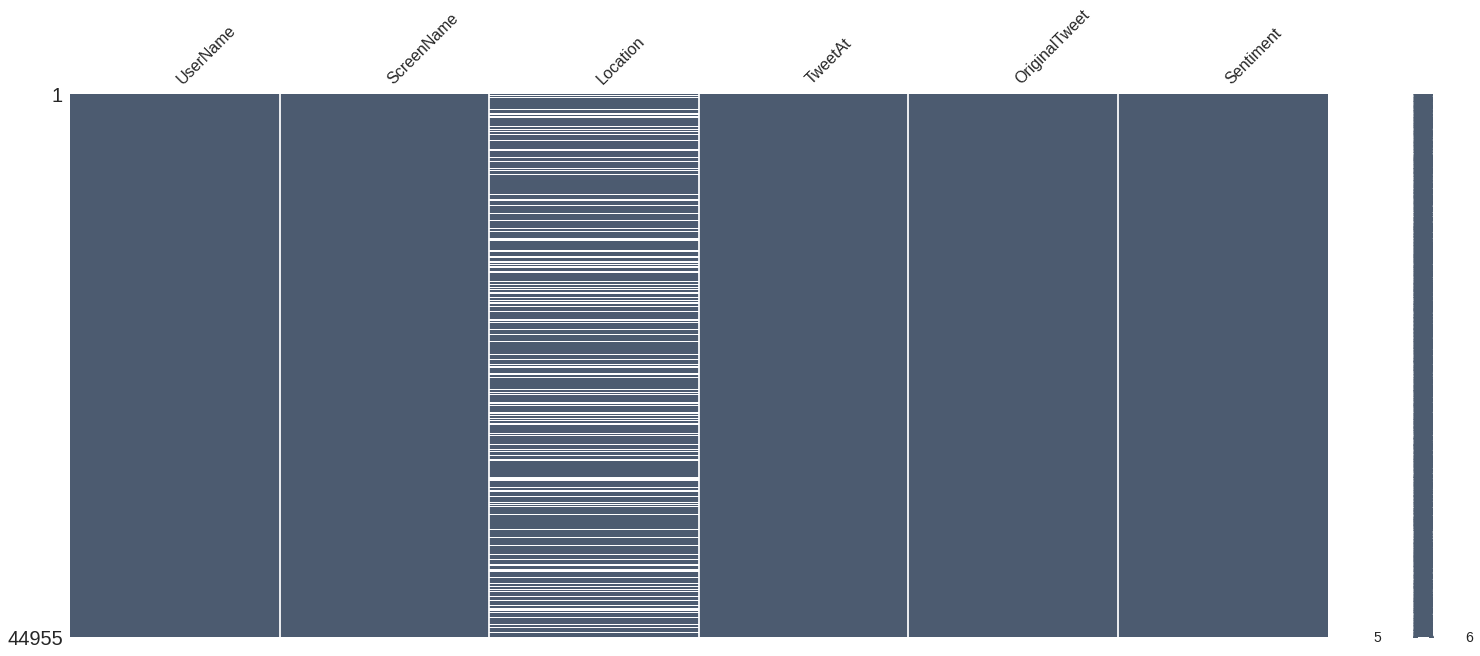

In [7]:
#Missing data as white lines 
import missingno as msno
msno.matrix(df,color=(0.3,0.36,0.44))

In [8]:
print('Total tweets in this data: {}'.format(df.shape[0]))
print('Total Unique Users in this data: {}'.format(df['UserName'].nunique()))

Total tweets in this data: 44955
Total Unique Users in this data: 44955


In [9]:
print(df.Sentiment.unique())
print(df.Sentiment.value_counts())

['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']
Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64


In [10]:
# We will copy the text in another column so that the original text is also there for comparison

df['text'] = df.OriginalTweet
df["text"] = df["text"].astype(str)

train['text'] = train.OriginalTweet
train["text"] = train["text"].astype(str)

test['text'] = test.OriginalTweet
test["text"] = test["text"].astype(str)

# Data has 5 classes, let's convert them to 3
# Data has "Extremely Positive","Extremely Negative","Negative","Positive",
#"neutral" but we only want to classify 3 of "Negative","Positive"and
#"neutral"
def classes_def(x):
    if x ==  "Extremely Positive":
        return "positive"
    elif x == "Extremely Negative":
        return "negative"
    elif x == "Negative":
        return "negative"
    elif x ==  "Positive":
        return "positive"
    else:
        return "neutral"
    
df['sentiment']=df['Sentiment'].apply(lambda x:classes_def(x))
train['sentiment']=train['Sentiment'].apply(lambda x:classes_def(x))
test['sentiment']=test['Sentiment'].apply(lambda x:classes_def(x))
target=df['sentiment']

df.sentiment.value_counts(normalize= True)

positive    0.435814
negative    0.378846
neutral     0.185341
Name: sentiment, dtype: float64

# **1.2 Class Distribution**

In [11]:
class_df = df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
class_df.style.background_gradient(cmap='winter')

,sentiment,text
2,positive,19592
0,negative,17031
1,neutral,8332


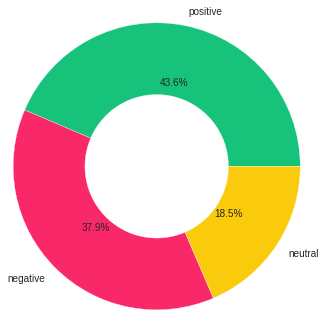

In [12]:
percent_class=class_df.text
labels= class_df.sentiment

colors = ['#17C37B','#F92969','#FACA0C']

my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,colors=colors,autopct="%.1f%%")

plt.setp(my_pie, width=0.6, edgecolor='white') 

plt.show()

In [13]:
fig=make_subplots(1,2,subplot_titles=('Train set','Test set'))
x=train.sentiment.value_counts()
fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['#17C37B','#F92969','#FACA0C'],name='train'),row=1,col=1)
x=test.sentiment.value_counts()
fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['#17C37B','#F92969','#FACA0C'],name='test'),row=1,col=2)

# 1.3 Number of characters

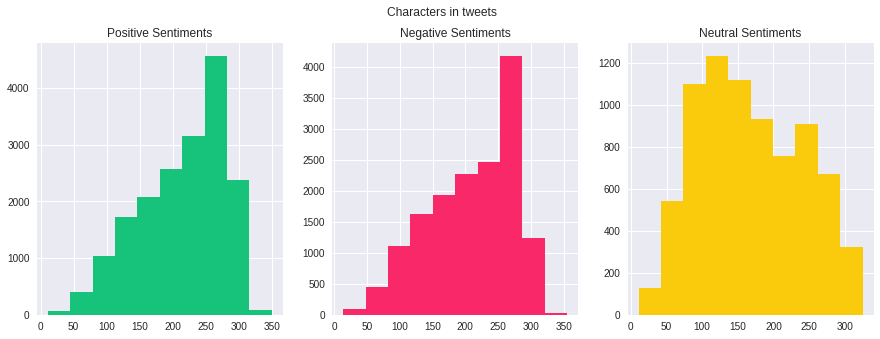

In [14]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=train[train['sentiment']=="positive"]['text'].str.len()
ax1.hist(tweet_len,color='#17C37B')
ax1.set_title('Positive Sentiments')

tweet_len=train[train['sentiment']=="negative"]['text'].str.len()
ax2.hist(tweet_len,color='#F92969')
ax2.set_title('Negative Sentiments')

tweet_len=train[train['sentiment']=="neutral"]['text'].str.len()
ax3.hist(tweet_len,color='#FACA0C')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Characters in tweets')
plt.show()

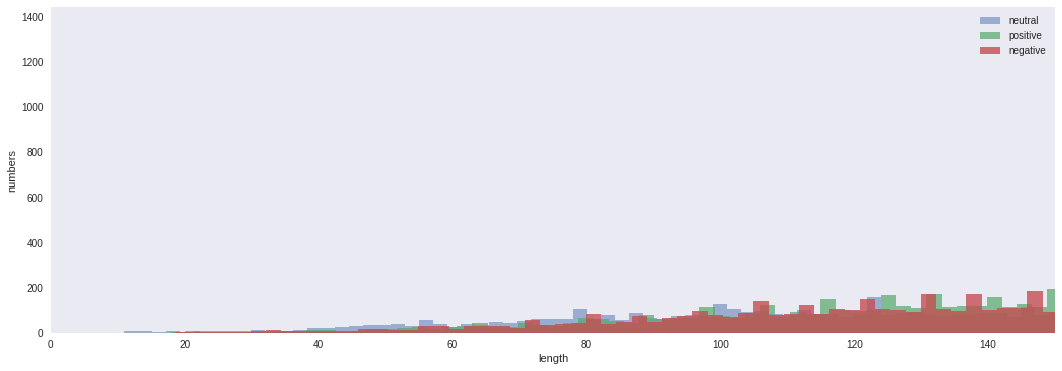

In [15]:
def length(text):    
    '''a function which returns the length of text'''
    return len(text)
df['length'] = df['text'].apply(length)

plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(df[df['sentiment'] == "neutral"]['length'], alpha = 0.5, bins=bins, label='neutral')
plt.hist(df[df['sentiment'] == "positive"]['length'], alpha = 0.7, bins=bins, label='positive')
plt.hist(df[df['sentiment'] == "negative"]['length'], alpha = 0.8, bins=bins, label='negative')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

# 1.4 Number of words in a tweet

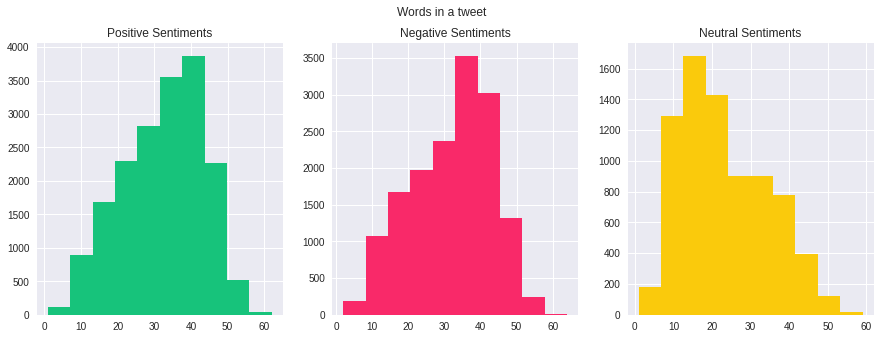

In [16]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=train[train['sentiment']=="positive"]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='#17C37B')
ax1.set_title('Positive Sentiments')


tweet_len=train[train['sentiment']=="negative"]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='#F92969')
ax2.set_title('Negative Sentiments')

tweet_len=train[train['sentiment']=="neutral"]['text'].str.split().map(lambda x: len(x))
ax3.hist(tweet_len,color='#FACA0C')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Words in a tweet')
plt.show()

# 1.5 Average word length in a tweet

Text(0.5, 0.98, 'Average word length in each tweet')

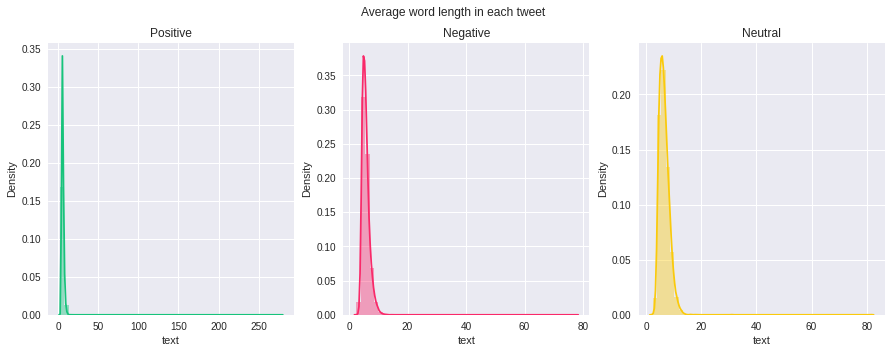

In [17]:
fig,(ax1,ax2, ax3)=plt.subplots(1,3,figsize=(15,5))

word=train[train['sentiment']=="positive"]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='#17C37B')
ax1.set_title('Positive')


word=train[train['sentiment']=="negative"]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='#F92969')
ax2.set_title('Negative')

word=train[train['sentiment']=="neutral"]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax3,color='#FACA0C')
ax3.set_title('Neutral')


fig.suptitle('Average word length in each tweet')

# 1.6 Common Stopwords in the tweets

In [18]:
def create_corpus(target):
    corpus=[]
    
    for x in train[train['sentiment']==target ]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [19]:
np.array(stop)

array({'while', 'shouldn', 'can', "don't", 'your', 'haven', "couldn't", 'this', 'am', 'wasn', 'off', 'we', 'from', 'had', "haven't", 'into', 'each', 'through', 'an', "aren't", "needn't", 'but', 'him', 'where', 'its', 'too', "she's", "shan't", 'before', 'she', 'theirs', "mustn't", "you've", 'that', 'below', 'then', 'having', "hasn't", 've', 'above', 'of', 'most', 'does', 'during', "isn't", "it's", 'our', 'was', 'further', 'who', 'he', "you're", 'they', 'there', 'mightn', 'because', 'and', 'd', 'which', "you'll", 'me', 'doesn', 'only', 'itself', "shouldn't", 'y', 'couldn', 'on', 'once', "wasn't", 'it', 'other', 'when', "won't", 'm', "doesn't", 'himself', 's', 'being', 'ours', 'now', 'her', "should've", 'themselves', 'will', 'll', 'more', 'with', 'again', 'a', 'did', 'after', 'them', 'under', 'up', 'myself', 'do', 'needn', "you'd", 'some', 'these', 'don', 'yourselves', 're', 'no', 'i', 'wouldn', 'mustn', 'to', 'ain', 'if', 'by', 'down', 'hers', 'out', 'hadn', 'herself', 'shan', 'yourself'

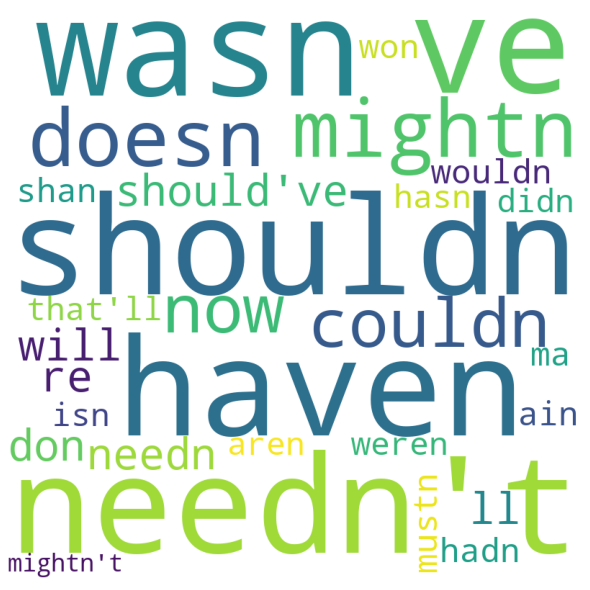

In [20]:
comment_words = '' 
stopwords = set(STOPWORDS) 
  

for val in stop: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = "white") 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

<BarContainer object of 10 artists>

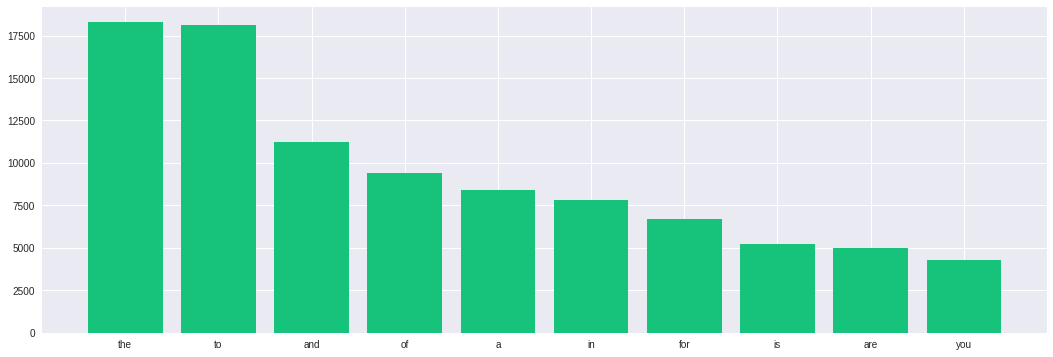

In [21]:
corpus=create_corpus("positive")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1     
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#17C37B')

<BarContainer object of 10 artists>

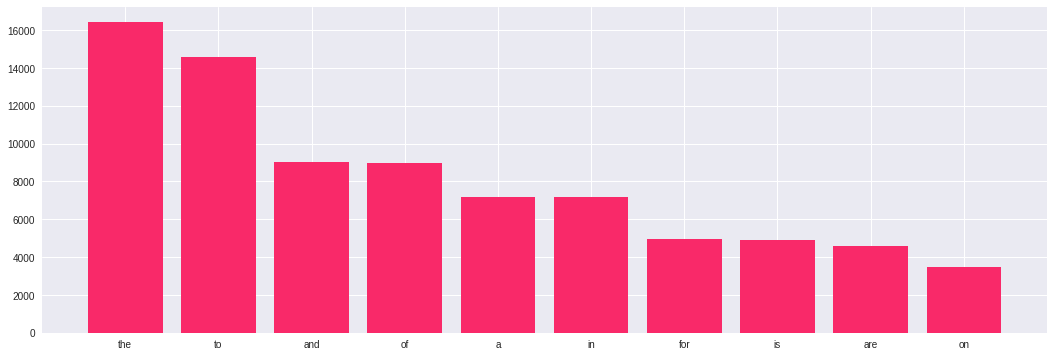

In [22]:
corpus=create_corpus("negative")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
          
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#F92969')

<BarContainer object of 10 artists>

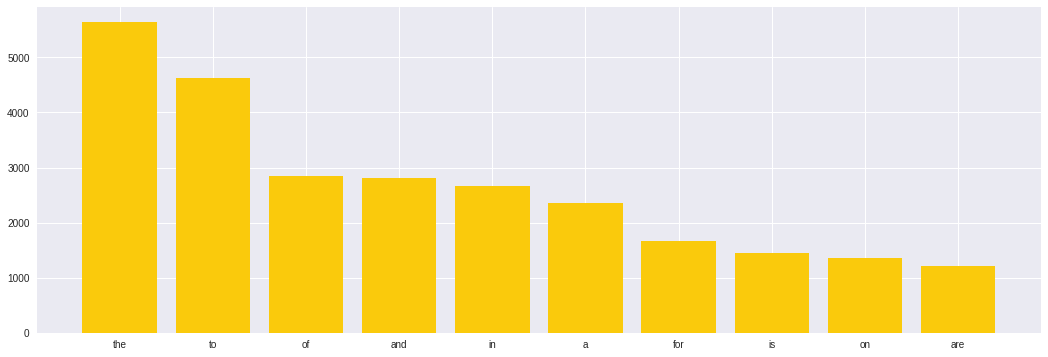

In [23]:
corpus=create_corpus("neutral")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
               
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#FACA0C')

# 1.7 Punctuations

<BarContainer object of 27 artists>

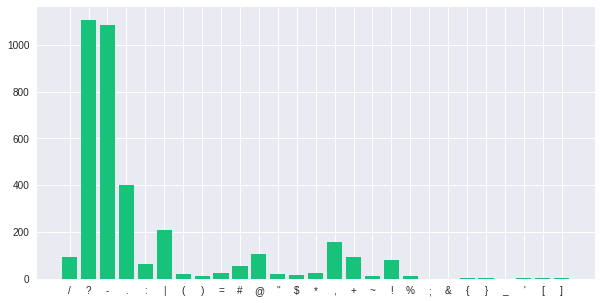

In [24]:
plt.figure(figsize=(10,5))
corpus=create_corpus("positive")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='#17C37B')

<BarContainer object of 25 artists>

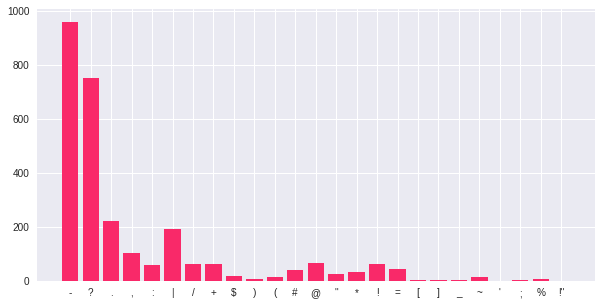

In [25]:
plt.figure(figsize=(10,5))
corpus=create_corpus("negative")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
                
x,y=zip(*dic.items())
plt.bar(x,y, color='#F92969')

<BarContainer object of 23 artists>

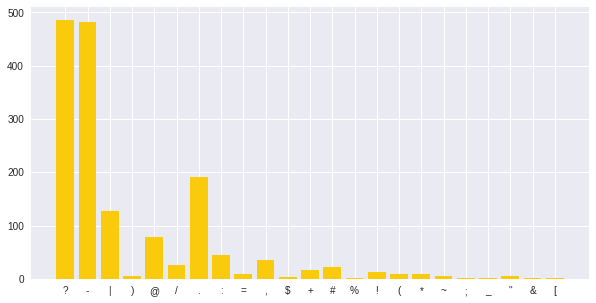

In [26]:
plt.figure(figsize=(10,5))
corpus=create_corpus("neutral")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1

        
x,y=zip(*dic.items())
plt.bar(x,y,color='#FACA0C')

# 1.8 Common Words

In [27]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

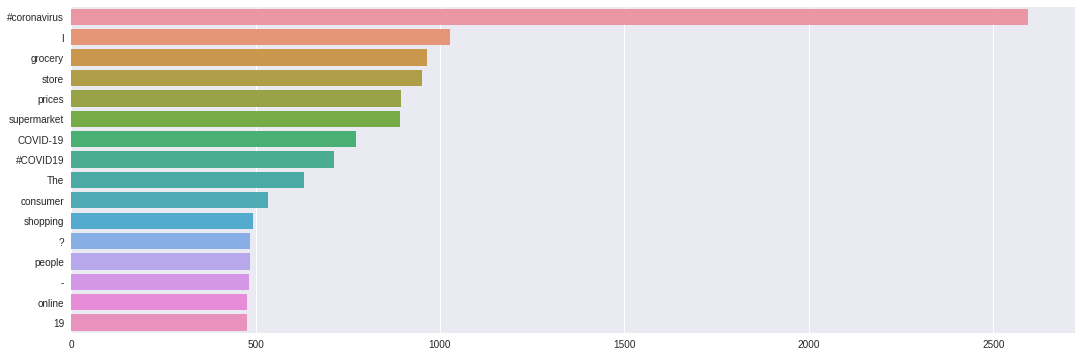

In [28]:
sns.barplot(x=y,y=x)

# 1.9 Hashtags

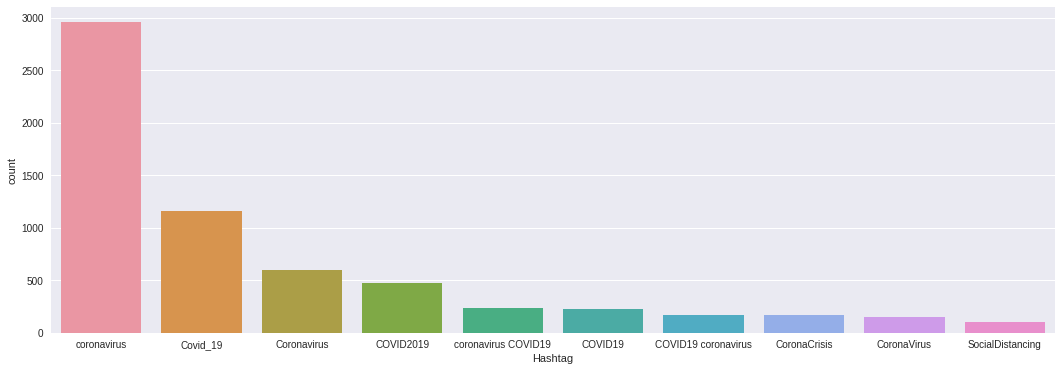

In [29]:
def find_hash(text):
    line=re.findall(r'(?<=#)\w+',text)
    return " ".join(line)
df['hash']=df['text'].apply(lambda x:find_hash(x))
temp=df['hash'].value_counts()[:][1:11]
temp= temp.to_frame().reset_index().rename(columns={'index':'Hashtag','hash':'count'})
sns.barplot(x="Hashtag",y="count", data = temp)

# 1.10 Mentions

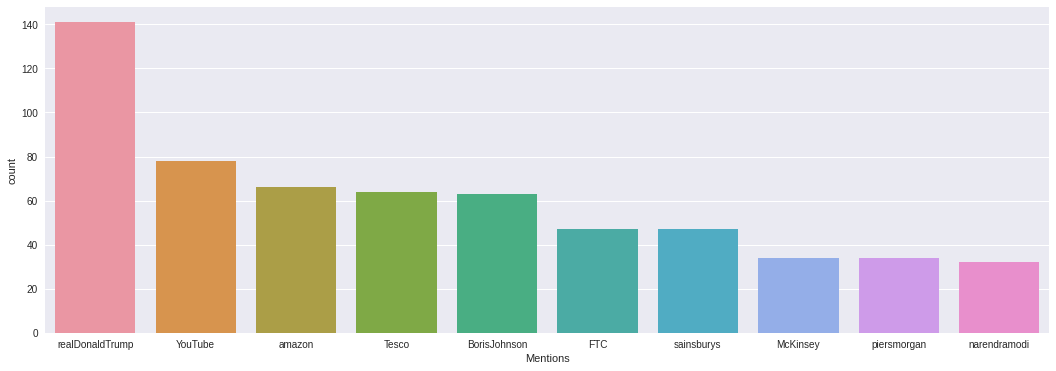

In [30]:
def mentions(text):
    line=re.findall(r'(?<=@)\w+',text)
    return " ".join(line)
df['mentions']=df['text'].apply(lambda x:mentions(x))

temp=df['mentions'].value_counts()[:][1:11]
temp =temp.to_frame().reset_index().rename(columns={'index':'Mentions','mentions':'count'})

sns.barplot(x="Mentions",y="count", data = temp)

# 1.11 Word Cloud


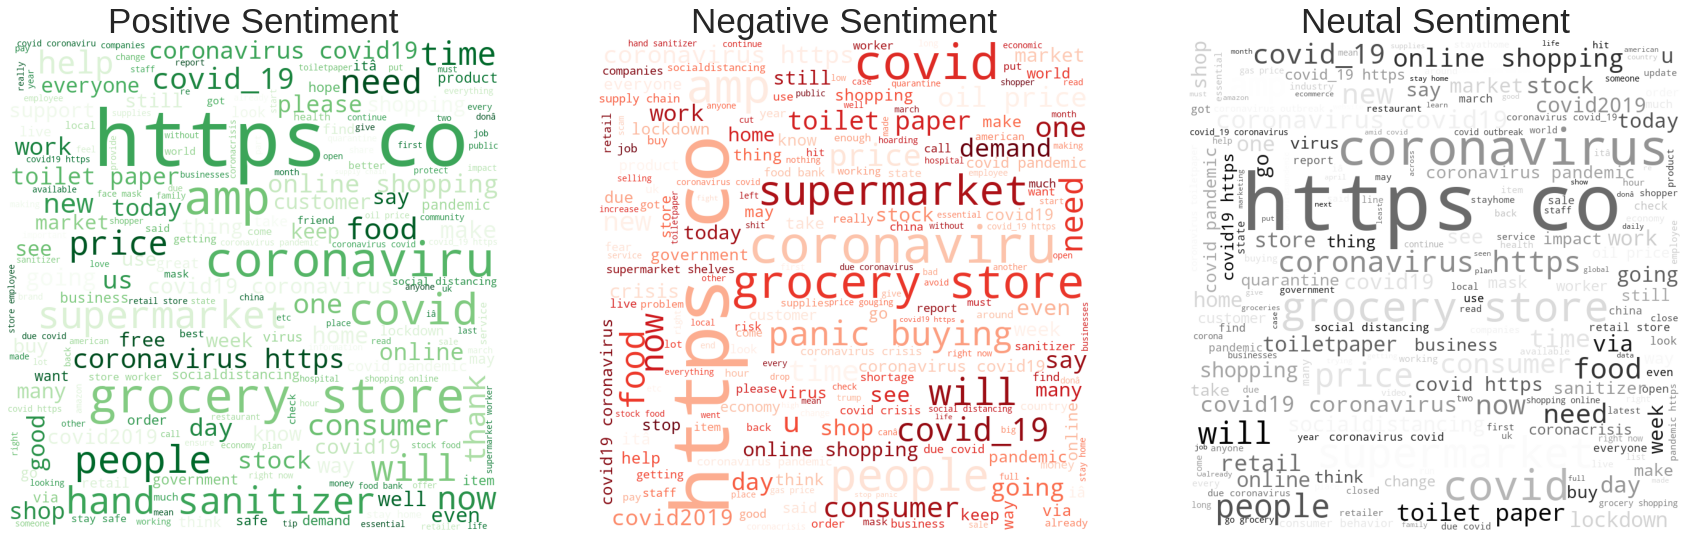

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])

df_pos = df[df["sentiment"]=="positive"]
df_neg = df[df["sentiment"]=="negative"]
df_neu = df[df["sentiment"]=="neutral"]

comment_words = '' 
stopwords = set(STOPWORDS) 

for val in df_pos.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
   

wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Greens",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive Sentiment',fontsize=35);

comment_words = ''

for val in df_neg.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "




wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Reds",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)  
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative Sentiment',fontsize=35);



comment_words = ''
for val in df_neu.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud3 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Greys",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutal Sentiment',fontsize=35);

# 2.Classfication with/without IDF
In this segment, we classify the data with/without IDF and show the current results.

# 2.1 Sample testing

In [32]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text,sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...,positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia: Woolworths to give elde...,positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...,positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"Me, ready to go at supermarket during the #COV...",negative


In [33]:
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text,sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,TRENDING: New Yorkers encounter empty supermar...,negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,When I couldn't find hand sanitizer at Fred Me...,positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,Find out how you can protect yourself and love...,positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative,#Panic buying hits #NewYork City as anxious sh...,negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,#toiletpaper #dunnypaper #coronavirus #coronav...,neutral


In [34]:
data_train=train['OriginalTweet']
sentiment_train=train['Sentiment']
data_test=test['OriginalTweet']
sentiment_test=test['Sentiment']

In [35]:
full_data=pd.concat([data_test,data_train])

In [36]:
#We want to see the training result so we take 50 samples as a epoch of sample
#to show the reult of the model
sample=data_train[:50]
sample_target=sentiment_train[:50]
sample_test=data_test[:10]

In [37]:
from nltk.stem import WordNetLemmatizer
WNL=WordNetLemmatizer()

In [38]:
def text_process(data):
    msg=[c for c in data if c not in string.punctuation]
    msg=''.join(msg)
    msg=[word for word in msg.split() if word.lower() not in stop]
    msg=[WNL.lemmatize(word) for word in msg ]
    return msg

In [39]:
sample

0     @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1     advice Talk to your neighbours family to excha...
2     Coronavirus Australia: Woolworths to give elde...
3     My food stock is not the only one which is emp...
4     Me, ready to go at supermarket during the #COV...
5     As news of the regionÂs first confirmed COVID...
6     Cashier at grocery store was sharing his insig...
7     Was at the supermarket today. Didn't buy toile...
8     Due to COVID-19 our retail store and classroom...
9     For corona prevention,we should stop to buy th...
10    All month there hasn't been crowding in the su...
11    Due to the Covid-19 situation, we have increas...
12    #horningsea is a caring community. LetÂs ALL ...
13    Me: I don't need to stock up on food, I'll jus...
14    ADARA Releases COVID-19 Resource Center for Tr...
15    Lines at the grocery store have been unpredict...
16    ????? ????? ????? ????? ??\r\r\n?????? ????? ?...
17    @eyeonthearctic 16MAR20 Russia consumer su

In [40]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
sample.apply(text_process)

0     [MeNyrbie, PhilGahan, Chrisitv, httpstcoiFz9FA...
1     [advice, Talk, neighbour, family, exchange, ph...
2     [Coronavirus, Australia, Woolworths, give, eld...
3     [food, stock, one, empty, PLEASE, dont, panic,...
4     [ready, go, supermarket, COVID19, outbreak, Im...
5     [news, regionÂs, first, confirmed, COVID19, c...
6     [Cashier, grocery, store, sharing, insight, Co...
7     [supermarket, today, Didnt, buy, toilet, paper...
8     [Due, COVID19, retail, store, classroom, Atlan...
9     [corona, preventionwe, stop, buy, thing, cash,...
10    [month, hasnt, crowding, supermarket, restaura...
11    [Due, Covid19, situation, increased, demand, f...
12    [horningsea, caring, community, LetÂs, look, ...
13    [dont, need, stock, food, Ill, Amazon, deliver...
14    [ADARA, Releases, COVID19, Resource, Center, T...
15    [Lines, grocery, store, unpredictable, eating,...
16                             [13, httpstco51bL8P6vZh]
17    [eyeonthearctic, 16MAR20, Russia, consumer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
CV=CountVectorizer(analyzer=text_process)
CV.fit(sample)

CountVectorizer(analyzer=<function text_process at 0x7f9cbcdb3170>,
                binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
CV.vocabulary_

{'10': 0,
 '100': 1,
 '101': 2,
 '10DowningStreet': 3,
 '12': 4,
 '13': 5,
 '16': 6,
 '16MAR20': 7,
 '18Movies': 8,
 '19': 9,
 '2': 10,
 '2019': 11,
 '412': 12,
 '65': 13,
 '7SealsOfTheEnd': 14,
 'ADARA': 15,
 'AMAZING': 16,
 'Adult': 17,
 'Africans': 18,
 'Also': 19,
 'Amazon': 20,
 'Apologies': 21,
 'Arctic': 22,
 'Atlanta': 23,
 'Australia': 24,
 'Behavior': 25,
 'Brands': 26,
 'Breaking': 27,
 'BreakingNews': 28,
 'BrickAndMortar': 29,
 'Bringing': 30,
 'CHEAP': 31,
 'CHECK': 32,
 'CNBC': 33,
 'COVID': 34,
 'COVID19': 35,
 'COVID19france': 36,
 'COVID2019': 37,
 'COVID2019usa': 38,
 'Cashier': 39,
 'Center': 40,
 'Cheap': 41,
 'Chrisitv': 42,
 'Cinema': 43,
 'Civics': 44,
 'Click': 45,
 'Closed': 46,
 'CoVid19': 47,
 'Coalition': 48,
 'Collapse': 49,
 'Confidence': 50,
 'ConfinementGeneral': 51,
 'Confinementotal': 52,
 'Consumer': 53,
 'Corona': 54,
 'CoronaVirus': 55,
 'CoronaVirusSA': 56,
 'Coronavirus': 57,
 'CoronavirusFrance': 58,
 'CoronavirusOutbreak': 59,
 'Country': 60,
 

In [ ]:
sample=CV.transform(sample)

In [ ]:
#non zero values
sample.nnz

928

In [ ]:
Tfidf=TfidfTransformer()
Tfidf.fit(sample)
Tfidf_val=Tfidf.transform(sample)

In [ ]:
#sample_test = str(sample_test)
sample_test=CV.transform(sample_test)
sample_test=Tfidf.transform(sample_test)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.pipeline import Pipeline

# 2.1 Classfication with IDF


(1) Naive Bayes

Much faster than IDF with Random Forest Classifier

In [ ]:
estimator1=[('CV',CountVectorizer(analyzer=text_process)),('Tfidf',TfidfTransformer()),('Final Analysis',MultinomialNB())]

pipe1=Pipeline(estimator1)

pipe1.fit(data_train,sentiment_train)

Pipeline(memory=None,
         steps=[('CV',
                 CountVectorizer(analyzer=<function text_process at 0x7f9cbcdb3170>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('Tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('Final Analysis',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
predict1=pipe1.predict(data_test)
print(classification_report(sentiment_test,predict1))

                    precision    recall  f1-score   support

Extremely Negative       0.50      0.00      0.00       592
Extremely Positive       1.00      0.02      0.04       599
          Negative       0.37      0.31      0.34      1041
           Neutral       0.74      0.03      0.05       619
          Positive       0.30      0.92      0.46       947

          accuracy                           0.32      3798
         macro avg       0.58      0.26      0.18      3798
      weighted avg       0.53      0.32      0.22      3798



In [ ]:
print(confusion_matrix(sentiment_test,predict1))

[[  1   0 352   1 238]
 [  0  12  18   0 569]
 [  1   0 327   5 708]
 [  0   0 113  17 489]
 [  0   0  72   0 875]]


In [ ]:
df1=pd.DataFrame()
df1['actual']=sentiment_test
df1['predicted']=predict1
df1.head(15)

,actual,predicted
0,Extremely Negative,Positive
1,Positive,Positive
2,Extremely Positive,Positive
3,Negative,Negative
4,Neutral,Negative
5,Neutral,Positive
6,Positive,Positive
7,Neutral,Positive
8,Extremely Negative,Positive
9,Extremely Positive,Positive


In [ ]:
count = np.sum(sentiment_test == predict1)

print("The accuracy with IDF using Naive Beyas:",count/len(df1))

The accuracy with IDF using Naive Beyas: 0.3243812532912059


(2)With Random Forest Classifier  


In [ ]:
estimator2=[('CV',CountVectorizer(analyzer=text_process)),('Tfidf',TfidfTransformer()),
            ('Final Analysis',RandomForestClassifier())]

pipe2=Pipeline(estimator2)

pipe2.fit(data_train,sentiment_train)


Pipeline(memory=None,
         steps=[('CV',
                 CountVectorizer(analyzer=<function text_process at 0x7f9cbcdb3170>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b'...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.

In [ ]:
predict2=pipe2.predict(data_test)

In [ ]:
print(classification_report(sentiment_test,predict2))



                    precision    recall  f1-score   support

Extremely Negative       0.61      0.26      0.36       592
Extremely Positive       0.68      0.29      0.41       599
          Negative       0.43      0.42      0.42      1041
           Neutral       0.46      0.68      0.55       619
          Positive       0.39      0.55      0.46       947

          accuracy                           0.45      3798
         macro avg       0.51      0.44      0.44      3798
      weighted avg       0.49      0.45      0.44      3798



In [ ]:
print(confusion_matrix(sentiment_test,predict2))

[[154   5 271  68  94]
 [  9 175  59  37 319]
 [ 63  17 439 224 298]
 [  6   9  82 421 101]
 [ 20  51 181 175 520]]


In [ ]:
df2=pd.DataFrame()
df2['actual']=sentiment_test
df2['predicted']=predict2

In [ ]:
df2.head(15)

,actual,predicted
0,Extremely Negative,Negative
1,Positive,Positive
2,Extremely Positive,Extremely Positive
3,Negative,Negative
4,Neutral,Neutral
5,Neutral,Positive
6,Positive,Positive
7,Neutral,Negative
8,Extremely Negative,Positive
9,Extremely Positive,Positive


In [ ]:
count = np.sum(sentiment_test == predict2)

print("The accuracy with IDF using Naive Beyas:",count/len(df2))

The accuracy with IDF using Naive Beyas: 0.44997367035281727


# 2.2 Classfication without IDF


（1）Naive Bayes

In [ ]:
estimator3=[('CV',CountVectorizer(analyzer=text_process)),('Tfidf',TfidfTransformer(use_idf=False)),
            ('Final Analysis',MultinomialNB())]
pipe3=Pipeline(estimator3)
pipe3.fit(data_train,sentiment_train)

Pipeline(memory=None,
         steps=[('CV',
                 CountVectorizer(analyzer=<function text_process at 0x7f9cbcdb3170>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('Tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=False)),
                ('Final Analysis',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
predict3=pipe3.predict(data_test)


In [ ]:
print(classification_report(sentiment_test,predict3))

                    precision    recall  f1-score   support

Extremely Negative       0.50      0.00      0.00       592
Extremely Positive       1.00      0.01      0.02       599
          Negative       0.37      0.27      0.31      1041
           Neutral       0.74      0.02      0.04       619
          Positive       0.30      0.94      0.45       947

          accuracy                           0.31      3798
         macro avg       0.58      0.25      0.17      3798
      weighted avg       0.53      0.31      0.21      3798



In [ ]:
print(confusion_matrix(sentiment_test,predict3))

[[  1   0 332   0 259]
 [  0   6  11   0 582]
 [  1   0 284   4 752]
 [  0   0  83  14 522]
 [  0   0  58   1 888]]


In [ ]:
df3=pd.DataFrame()
df3['actual']=sentiment_test
df3['predicted']=predict3

In [ ]:

count = np.sum(sentiment_test == predict3)

print("The accuracy without IDF using Naive Beyas:",count/len(df3))

The accuracy without IDF using Naive Beyas: 0.3141126908899421


（2）Random Forest Classifier

In [ ]:
estimator4=[('CV',CountVectorizer(analyzer=text_process)),('Tfidf',TfidfTransformer(use_idf=False)),
            ('Final Analysis',RandomForestClassifier())]
pipe4=Pipeline(estimator4)
pipe4.fit(data_train,sentiment_train)

Pipeline(memory=None,
         steps=[('CV',
                 CountVectorizer(analyzer=<function text_process at 0x7f9cbcdb3170>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b'...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.

In [ ]:
predict4=pipe4.predict(data_test)

In [ ]:
print(classification_report(sentiment_test,predict4))

                    precision    recall  f1-score   support

Extremely Negative       0.62      0.29      0.40       592
Extremely Positive       0.64      0.33      0.44       599
          Negative       0.44      0.43      0.44      1041
           Neutral       0.47      0.65      0.55       619
          Positive       0.39      0.55      0.45       947

          accuracy                           0.46      3798
         macro avg       0.51      0.45      0.45      3798
      weighted avg       0.49      0.46      0.45      3798



In [ ]:
print(confusion_matrix(sentiment_test,predict4))

[[172   6 252  59 103]
 [  8 200  49  27 315]
 [ 75  23 447 209 287]
 [  3   6  91 404 115]
 [ 19  76 171 164 517]]


In [ ]:
df4=pd.DataFrame()
df4['actual']=sentiment_test
df4['predicted']=predict4
df4.head(15)

,actual,predicted
0,Extremely Negative,Negative
1,Positive,Positive
2,Extremely Positive,Positive
3,Negative,Negative
4,Neutral,Negative
5,Neutral,Neutral
6,Positive,Positive
7,Neutral,Negative
8,Extremely Negative,Positive
9,Extremely Positive,Positive


In [ ]:
df4.head(15)

,actual,predicted
0,Extremely Negative,Negative
1,Positive,Positive
2,Extremely Positive,Positive
3,Negative,Negative
4,Neutral,Negative
5,Neutral,Neutral
6,Positive,Positive
7,Neutral,Negative
8,Extremely Negative,Positive
9,Extremely Positive,Positive


In [ ]:
count = np.sum(sentiment_test == predict4)

print("The accuracy with IDF using Naive Beyas:",count/len(df4))

The accuracy with IDF using Naive Beyas: 0.45813586097946285


# 2.3 Word Cloud

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
%matplotlib inline

In [ ]:
def one_sentence(data):
    msg=' '.join(data)
    return msg
def join_all(data):
    msg = " "
    for i in data:
        msg = msg + i
    return msg

In [ ]:
full_data=full_data.apply(text_process)
full_data=full_data.apply(one_sentence)

In [ ]:
whole=join_all(full_data)
#whole

(-0.5, 399.5, 199.5, -0.5)

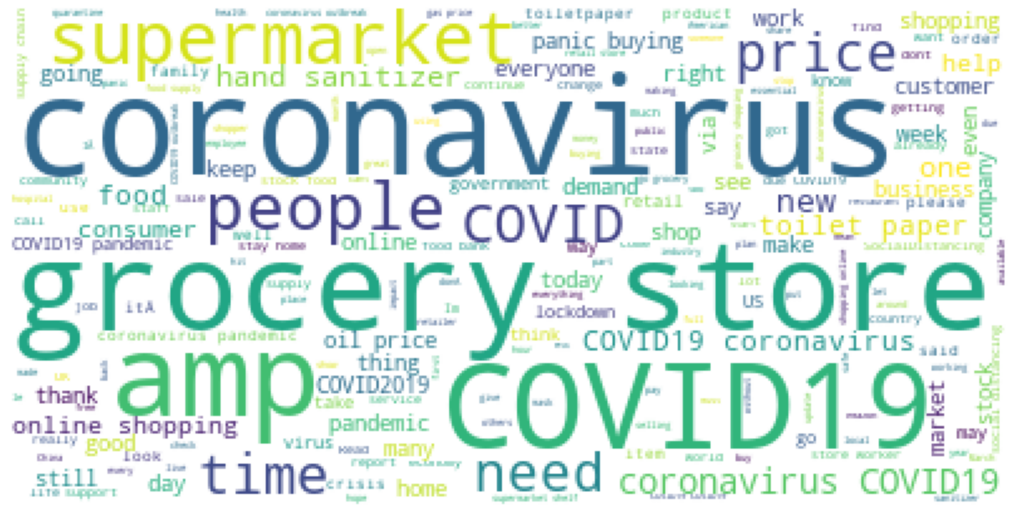

In [ ]:
plt.figure(figsize=(18,10))
wordcloud=WordCloud(background_color='white').generate(whole)
plt.imshow(wordcloud)
plt.axis('off')

# 3. Optimizing

According to the result of Bayes and random forest, the accuracy is 
only about 40%, so low for us to predict. As a result we want to find some other algorithms to replace them

# 3.1 LSTM


In [ ]:
import pandas as pd
import numpy as np